## 08. PyTorch Paper Replicating

### Milestone Project 2: PyTorch Paper Replicating

=> replicating a Machine Learning research paper and creating a Vision Transformer(ViT) from scrach using PyTorch.

#### • What is paper replicating?

=> many of advances get published in machine learning research papers.

**=> Goal of paper replicating:** take replicate advances with code -> use the techniques for own problem

**=> Involves:** *turn a machine learning paper comprised of images/digrams, math and test into usable code and in this case, usable PyTorch code. Digram, math equations and test from the `ViT paper.`*

#### • What is a machine learning research paper?
> (1) **Abstract** -> An overview/summary of the paper's main findings/contributions
>
> (2) **Introduction** -> What's the paper's main problem and details of previous methods used to try and solve it.
>
> (3) **Method** -> How did the researchers go about conducting their research? -> what model(s), data sources, training setups were used?
>
> (4) **Results** -> outcomes -> If a new type of model or training setup was used, how did the results of findings compare to previous works?
>
> (5) **Conclusion** -> limitations of the suggested methods? next steps for the research community?
>
> (6) **References** -> resources/other papers did the researchers look at to build their own body of work?
>
> (7) **Appendix** -> any extra resources/findings to look at
>


#### • Where to find code examples for ML research paper?
> (1) **arXiv** -> a free and open resource for reading technical articles on everything from physics to computer science
>
> (2) **AK Twitter** -> The AK Twitter account publishes machine learning research highlights, often with live demos almost every day
>
> (3) **Paper with Code** -> collection of trending, active and greatest machine learning papers, many of which include code resources attached. Also includes a collection of common machine learning datasets, benchmarks and current state-of-the-art models.
>
> (4) **lucidrains' `vit-pytorch` GitHub repository** -> Less of a place to find research papers and more of an example of what paper replicating with code on a larger-scale and with a specific focus looks like. 
>
> ...

### 0. Get Setup

=> replicate the machine learning research paper `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale` (ViT paper) with PyTorch - https://arxiv.org/abs/2010.11929

=> The `Transformer neural network architecture` was originally introduced in the machine learning research paper `Attention is all you need` - https://arxiv.org/abs/1706.03762

=> A `Transformer architecture` is generally considered to be any neural network that uses the `attention mechanism` as its **primary learning layer**. Similar to a how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

=> the `Vision Transformer (ViT) architecture` was designed to adapt the original Transformer architecture to vision problem(s)

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [2]:
from go_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

'mps'

### 1. Get Data

=> continue on with FoodVision Mini -> still use the pizza, steak, sushi image dataset

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2. Create Dtasets and DataLoaders

=> use the `create_dataloaders()` function in `data_setup.py`.

• the training resolution is mentioned as being 224 (height=224, width=224)

In [5]:
from go_modular import data_setup
from torchvision import transforms

# Create image size -> comes from Table 3 of the ViT paper
IMG_SIZE = 224

# Create transforms pipline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [7]:
# get a single image and label from a batch of data and inspect their shapes

# get a batch of images
img_batch, label_batch = next(iter(train_dataloader))

# get a single image and label
img, label = img_batch[0], label_batch[0]

# view the shape
img.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

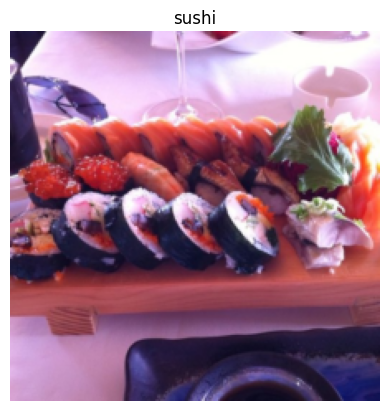

In [8]:
# plot the image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

### 3. Replicating the ViT paper

=> Terms:
- **Inputs** -> what goes into the model
- **Outputs** -> what comes out of the model/layer/block
- **Layer** -> takes an input, performs a function on it, returns an output
- **Block** -> a collection of layers
- **Architecture (mdoel)** -> a collection of blocks

#### 3.1 ViT Overview

- **Figure 1**: Visual overview of the architecture
- **Four equations** in Section 3.1: math equations which define the functions of each layer/block (mathematical grounding to the coloured blocks in Figure 1)
- **Table 1/3**: different hyperparameters for the architecture/training -> focused on the smallest version, ViT-Base
- Text descriptions (especially section 3.1)

##### 3.1.1 Figure 1

<img src="images/08-vit-paper-figure-1.png" width=700 alt="figure 1 from vision transformer paper"/>

- Embedding = learnable representation (start with random numbers and improve over time) 

**The ViT architecture is comprised of several stages:**
> • **Patch + Position Embedding (inputs)** - turns the input image into a sequence of images patches and add a position number what order the patch comes in
>
> • **Linear projection of flatterned patched (Embedded Patched)** - the image patched get turned into an *embedding* => benefit of embedding (rather than just image values) -> an embedding is a *learnable* representation of the image that can improving with training
>
> • **Norm** - (*Layer Normalization/LayerNorm*) - a technique for regularizing (reducing overfitting) a neural network -> `torch.nn.LayerNorm()`
>
> • **Multi-Head Attention** - (*Multi-Headed Self-Attention layer/MSA*) -> create an MSA layer via: `torch.nn.MultiheadAttention()`
>
> • **MLP(Multilayer perceptron)** - any collection of feedforward layers => contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between them, and a `torch.nn.Dropout()` layer after each
>
> • **Transformer Encoder** - a collection of the layers listed above. => *2 skip connections* inside the Transformer encoder (the "+" symbols) -> the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
>
> • **MLP Head** (the classifier head) - the *output layer* of the architecture => converts the learned features of an input to a class output. => the structure of the MLP Head is similar to the MLP block
>



**Take Figure 1 and adapt it to FoodVision Mini problem of classifing images of food**

<img src="images/08-vit-paper-figure-1-food-mini.png" width=700 alt="adapt figure 1 to Food Mini"/>

##### 3.1.2 Four Equations

=> represent the math behind the four major parts of the ViT architecture

<img src="images/08-vit-paper-four-equations.png" width=700 alt="adapt figure 1 to Food Mini"/>

> `Equation(1):` The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where \
> • $(H, W)$ is the *resolution of the original image*, \
> • $C$ is the *number of channels*, \
> • $(P, P)$ is the *resolution of each image patch*, \
> • $N=H W / P^{2}$ is the *resulting number of patches*, which also serves as the effective input sequence length for the Transformer. 
> 
> -> The Transformer uses **constant latent vector size $D$** through all of its layers, \
> -> so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1) -> refer to the output of this projection as the patch embeddings.
> 
> => **Position embeddings** are added to the **patch embeddings** to *retain positional information*. \
> => use standard learnable $1 \mathrm{D}$ position embeddings -> since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.
> 
> \
> **=> In pseudocode:**
>
> ```python
> # Equation 1
> x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
> ```
> 


> `Equation(2)&(3):` The Transformer encoder (Vaswani et al., 2017) consists of *alternating layers of multiheaded selfattention* (*MSA*, see Appendix A) and *MLP blocks*(Eq. 2, 3). \
> **Layernorm (LN) is applied before every block**, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).
>
> \
> **=> In pseudocode:**
> ```python
> # Equation 2 
> x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
>
> # Equation 3 
> x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
> ```
>

> `Equation(4):` Similar to BERT's [ class ] token. \
> => prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, \
> whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). \
> => Both during *pre-training* and *fine-tuning*, a classification head is attached to $\mathbf{z}_{L}^{0}$. \
> => The classification head is implemented by a *MLP* with \
> • one hidden layer at pre-training time \
> • and by a single linear layer at fine-tuning time.
>
> * MLP = multilayer perceptron = a neural network with X number of layers
> * MLP = one hidden layer at training time
> * MLP = single linear layer at fine-tuning time 
>
> 
> **=> In pseudocode:**
> ```python
> # Equation 4 
> y = Linear_layer(LN_layer(x_output_MLP_block)) 
> ```

**Map to the ViT architecture in Figure 1**

<img src="images/08-vit-paper-map-equations-to-figure-1.png" width=700 alt="adapt figure 1 to Food Mini"/>

##### 3.1.3 Table 1

<img src="images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

> • **ViT-Base**, **ViT-Large** and **ViT-Huge** are all different sizes of the same model architecture
>
> • **ViT-B/16** = ViT-Base with image patch size 16x16 
>
> • **Layers** - the number of transformer encoder layers 
>
> • **Hidden size $D$** - the embedding size throughout the architecture
>
> • **MLP size** - the number of hidden units/neurons in the MLP
>
> • **Heads** - the number of multi-head self-attention 
>

### 4. Equation 1: Split data into patches and creating the class, position and patch embedding

#### 4.1 Calculate input and output shapes

- **Input shape:** $H\times{W}\times{C}$ (height x width x color channels)
- **Output shape:** ${N \times\left(P^{2} \cdot C\right)}$
- H = height, W = width, C = color channels, P = patch size
- N = number of patches = (height * width) / $p^{2}$
- D = constant latent vector size = embedding dimension (see Table 1)

In [9]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the number of patches
num_of_patches = int((height * width) / patch_size ** 2)
num_of_patches

196

In [12]:
# Input shape
embed_layer_input_shape = (height, width, color_channels)

# Output shape
embed_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embed_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embed_layer_output_shape} -> (num_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (num_of_patches, embedding_dimension)


#### 4.2 Turn a single image into patches

torch.Size([3, 224, 224])


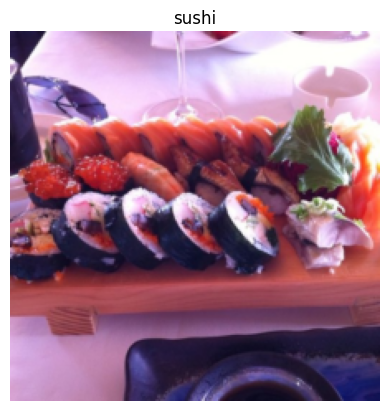

In [13]:
# View a single image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(img.shape)

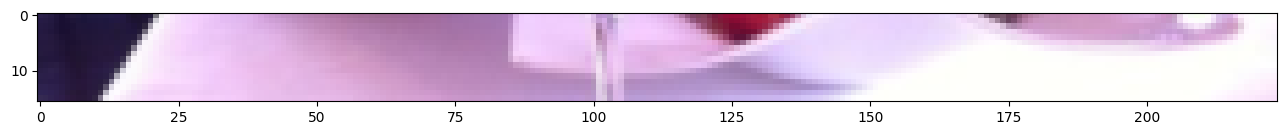

In [14]:
# get the top row of the image
img_permuted = img.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


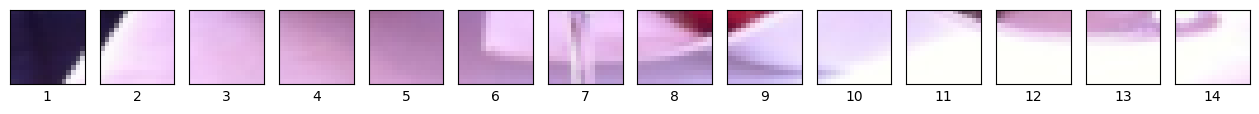

In [16]:
# plot top row as patches
row_size = 224
patch_size = 16
num_row_patches = row_size/patch_size 
assert row_size % patch_size == 0, "Row size must be divisible by patch size"
print(f"Number of patches per row: {num_row_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=row_size // patch_size,  # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# iterate through number of patches in the top row
for i, patch in enumerate(range(0, row_size, patch_size)):
    axs[i].imshow(img_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


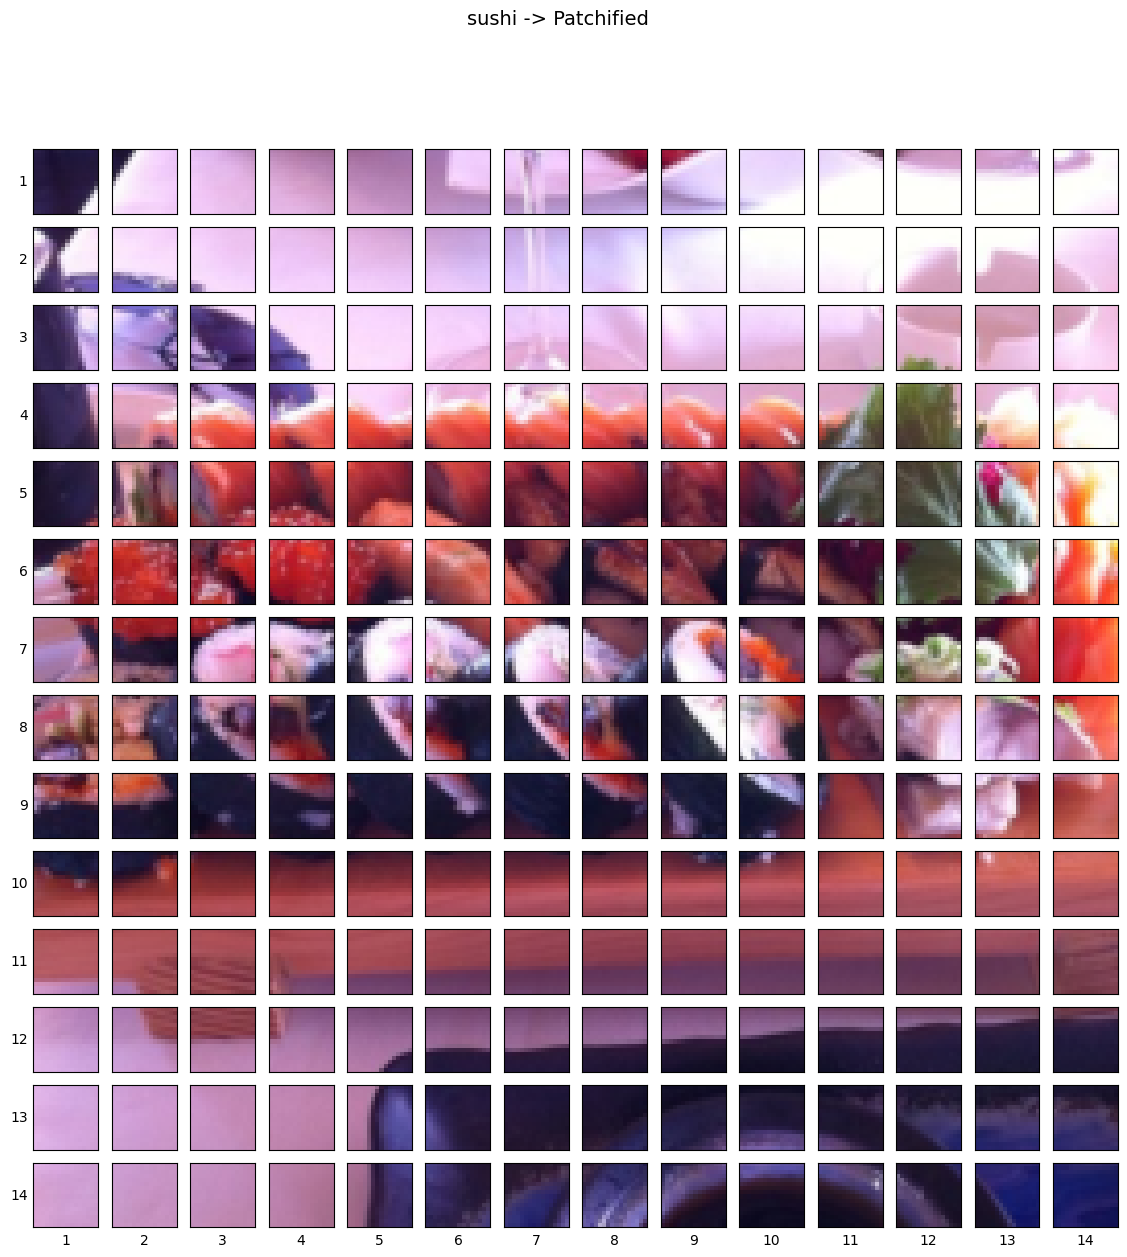

In [17]:
# try to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches*num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size ,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(num_patches, num_patches))

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(img_permuted[patch_height:patch_height+patch_size,
                                      patch_width:patch_width+patch_size,
                                      :])   # get all color channels
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

#### 4.3 Create image patches and turn them into patch embeddings

=> create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and set the kernel size and stride parameters to `patch_size`

In [18]:
from torch import nn

# Set the patch size 
patch_size = 16

# Create a conv2d lyaer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,       # for color images
                   out_channels=768,    # D size from Table 1 for ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [20]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(img.unsqueeze(0)) # add batch dimension
print(image_out_of_conv.shape) 

torch.Size([1, 768, 14, 14])


In [21]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [133, 712, 637, 500, 437]


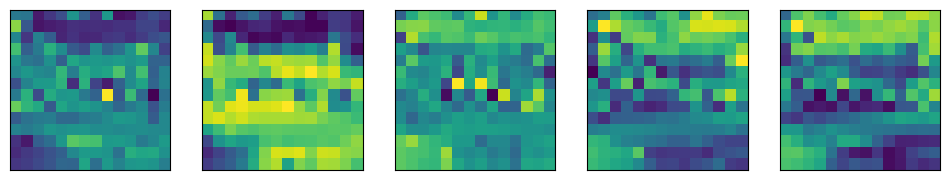

In [22]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    # index on the output tensor of the conv2d layer
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    # remove batch dimension
    # and remove from grad tracking/switch to numpy for matplotlib
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [23]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.3432,  0.1843,  0.1738,  0.1138,  0.1201,  0.1967,  0.0777,
            0.0792,  0.2672,  0.2444,  0.2396,  0.1301,  0.1382,  0.2031],
          [-0.0587,  0.0818,  0.1816,  0.1979,  0.1823,  0.1753,  0.2328,
            0.2341,  0.2651,  0.2618,  0.2694,  0.2469,  0.2542,  0.2143],
          [ 0.3066,  0.0704,  0.0903,  0.2659,  0.2176,  0.1843,  0.2503,
            0.2090,  0.1994,  0.2182,  0.2375,  0.1755,  0.1650,  0.1438],
          [ 0.0981,  0.1453,  0.1119, -0.0201,  0.1917,  0.2425,  0.1484,
            0.1018,  0.1042,  0.2054,  0.0347,  0.1868,  0.2069,  0.2339],
          [ 0.0926,  0.0943,  0.1183,  0.0263,  0.0648,  0.0236, -0.0316,
            0.0614,  0.0370,  0.0385,  0.0138,  0.1587,  0.1656,  0.4314],
          [-0.1285, -0.0277, -0.1477, -0.0673,  0.1176,  0.1458, -0.0543,
            0.0322, -0.0234,  0.0169,  0.0106,  0.0620,  0.1105, -0.0021],
          [-0.0523,  0.0997, -0.0054, -0.0850,  0.0537, -0.0423, -0.0725,
           -0.0544,  0.1655,  0.